In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots
from pmdarima.arima import auto_arima

In [2]:
plt.style.use('fivethirtyeight')

# Carregamento e validação dos dados

In [3]:
df = pd.read_csv(os.path.join('dataset.csv'))

In [4]:
print(df.dtypes)

ID_UNICO                   object
DT_ABERTURA                object
DT_HOMOLOGACAO             object
NM_ORGAO                   object
DS_OBJETO                  object
DS_ITEM                    object
QT_ITENS                  float64
VL_UNITARIO_HOMOLOGADO    float64
VL_TOTAL_HOMOLOGADO       float64
DS_OBJETO_RESUMIDO         object
DS_ITEM_RESUMIDO           object
dtype: object


In [5]:
df['DT_ABERTURA'] = pd.to_datetime(df['DT_ABERTURA'])
df['DT_HOMOLOGACAO'] = pd.to_datetime(df['DT_HOMOLOGACAO'])
df.dtypes

ID_UNICO                          object
DT_ABERTURA               datetime64[ns]
DT_HOMOLOGACAO            datetime64[ns]
NM_ORGAO                          object
DS_OBJETO                         object
DS_ITEM                           object
QT_ITENS                         float64
VL_UNITARIO_HOMOLOGADO           float64
VL_TOTAL_HOMOLOGADO              float64
DS_OBJETO_RESUMIDO                object
DS_ITEM_RESUMIDO                  object
dtype: object

In [10]:
df.DS_OBJETO_RESUMIDO = df.DS_OBJETO_RESUMIDO.astype('str').apply(lambda x: x.upper())
df.DS_ITEM_RESUMIDO = df.DS_ITEM_RESUMIDO.astype('str')

A principio, a quantidade de itens será relacionada ao número de licitações e não a quantidade total comprada.

In [11]:
df.DS_OBJETO_RESUMIDO.value_counts()

DS_OBJETO_RESUMIDO
MATERIAL        395055
ALIMENTO        200035
MEDICAMENTOS    128192
PEÇAS            42027
EQUIPAMENTOS     36500
                 ...  
TRANSDUTOR           1
CODEPAS              1
PRINCIPAL            1
IMOVEL               1
LIXOS                1
Name: count, Length: 3223, dtype: int64

In [12]:
df.DS_ITEM_RESUMIDO.value_counts()

DS_ITEM_RESUMIDO
PAPEL                21091
PNEU                 17705
FITA                 13406
FILTRO               13265
LUVA                 12597
                     ...  
GLICOSAMINA,SULF.        1
FÓRMULA/                 1
GAZIA                    1
ESTAMPAS                 1
VULCANISAÇÃO             1
Name: count, Length: 27417, dtype: int64

# Analise exploratória

In [14]:
# Cria duas listas com os 5 itens e categorias (objetos) com maior numero de licitações
# Cada lista armazena o nome na primeira posição e o número de ocorrências na segunda

top5_items = [df.DS_ITEM_RESUMIDO.value_counts().index[:5], df.DS_ITEM_RESUMIDO.value_counts()[:5]]
top5_objetos = [df.DS_OBJETO_RESUMIDO.value_counts().index[:5], df.DS_OBJETO_RESUMIDO.value_counts()[:5]]

Text(0.5, 0.98, 'Categorias e itens comprados com maior frequência')

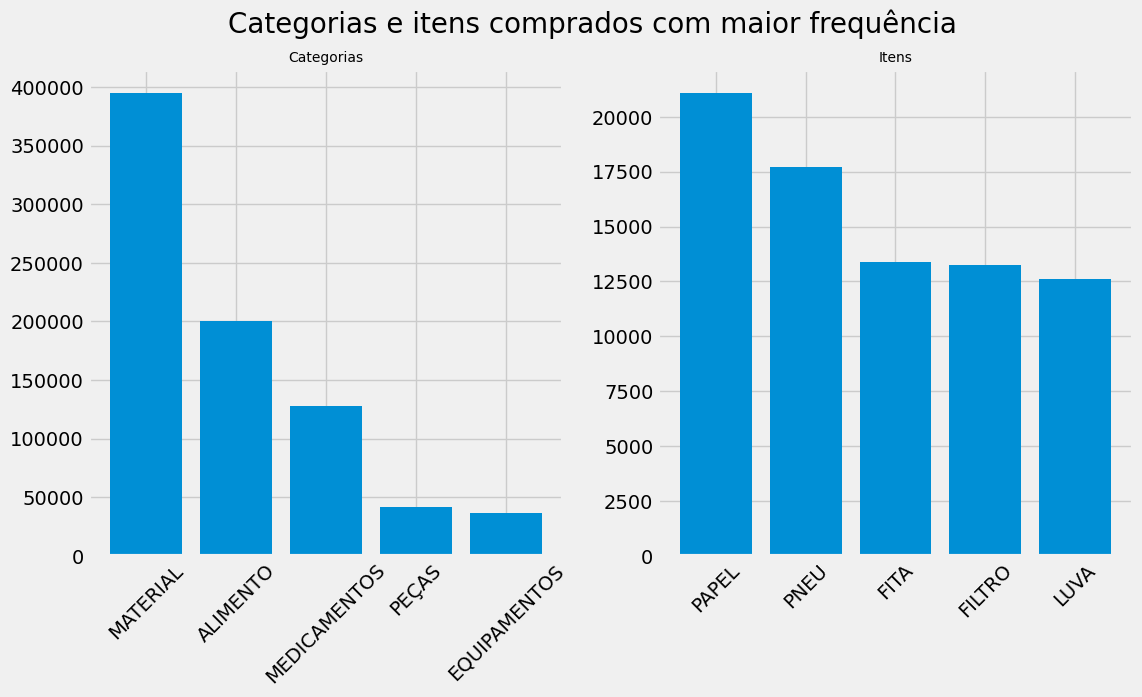

In [26]:
# Visualização das categorias e itens

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,6))

ax[0].bar(top5_objetos[0], top5_objetos[1])
ax[0].tick_params(labelrotation=45,axis='x')
ax[0].set_title('Categorias', fontsize=10)

ax[1].bar(top5_items[0], top5_items[1])
ax[1].tick_params(labelrotation=45,axis='x')
ax[1].set_title('Itens', fontsize=10)

fig.suptitle('Categorias e itens comprados com maior frequência',fontsize=20)

A maior parte das licitações envolvem materiais, alimentos e medicamentos, itens necessários no dia a dia. Os gráficos abaixo mostram os principais itens comprados em cada categoria.

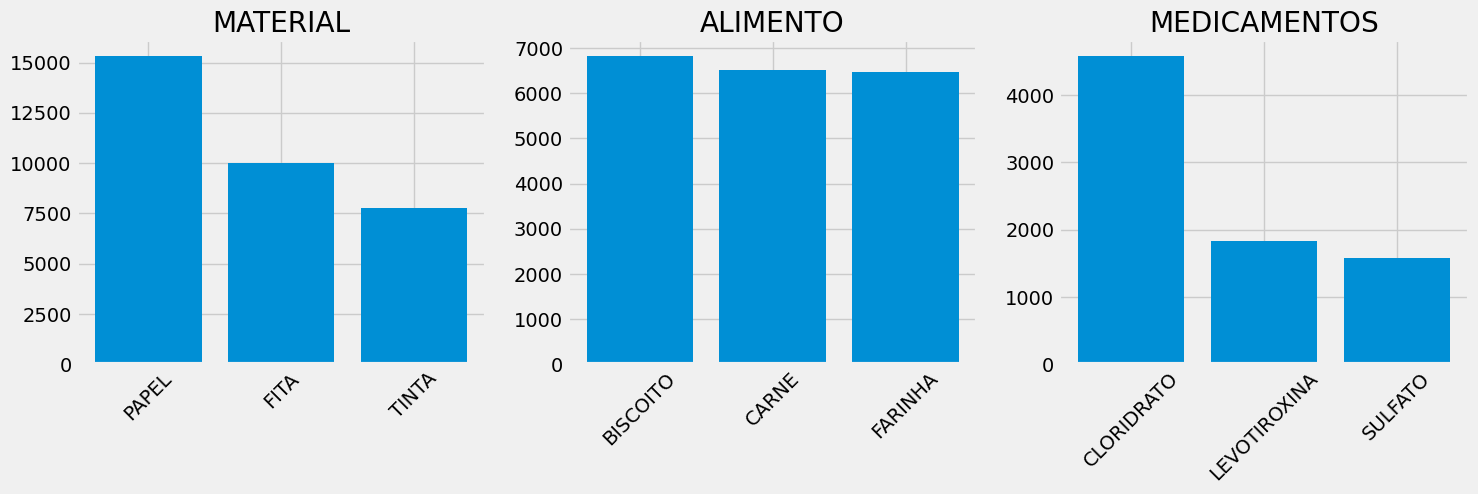

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(16,4))

for i, obj in enumerate(top5_objetos[0][:3]):
    filter_obj = df[df.DS_OBJETO_RESUMIDO == obj]
    top3_values = [filter_obj.DS_ITEM_RESUMIDO.value_counts().index[:3], filter_obj.DS_ITEM_RESUMIDO.value_counts()[:3]]
    ax[i].bar(top3_values[0], top3_values[1])
    ax[i].tick_params(labelrotation=45,axis='x')
    ax[i].set_title(obj.upper())


# Series temporais

In [28]:
# Cria um dataset para analise de séries temporais.
# A data de abertura é usada como index e a análise será nas categorias.

df_series = df[['DT_ABERTURA', 'DS_OBJETO_RESUMIDO']]\
            .set_index('DT_ABERTURA')

# Número de aberturas de licitação. Uma para cada observação
df_series.columns = ['ABERTURAS']
df_series['ABERTURAS'] = 1

# Realiza a soma para obtermos dados diários
df_series = df_series.resample('d').sum()

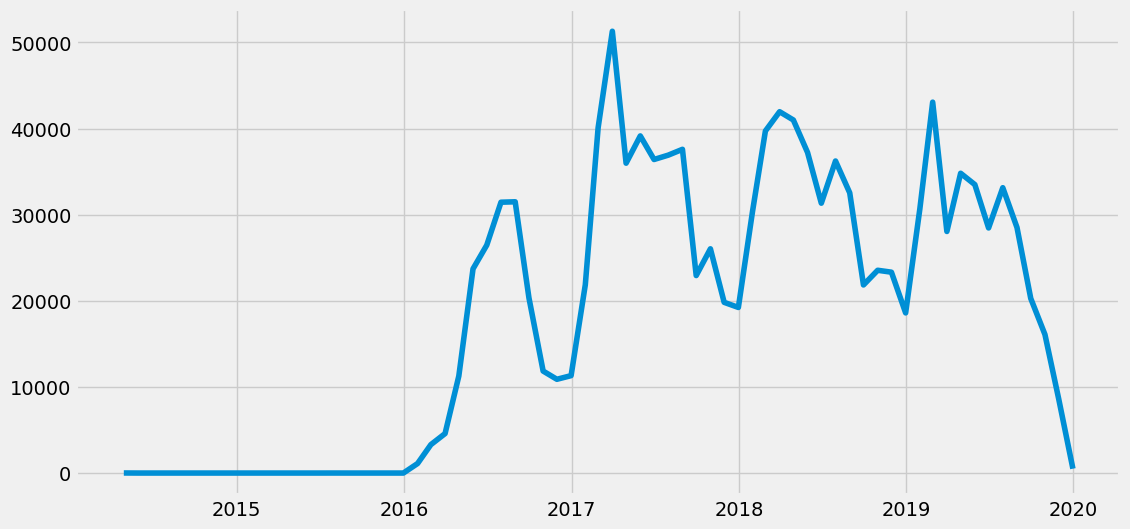

In [29]:
# resample('M) mostra os dados mensais. Será mais útil para a análise.

plt.figure(figsize=(12,6))
plt.plot(df_series.resample('M').sum().index, df_series.resample('M').sum().ABERTURAS)

Alguns dados possuem abertura de licitação anterior a 2016. Vamos utilizar apenas de janeiro de 2016 à dezembro de 2019

In [33]:
df_series = df[['DT_ABERTURA', 'DS_OBJETO_RESUMIDO']]\
            .set_index('DT_ABERTURA')
df_series.columns = ['ABERTURAS']
df_series['ABERTURAS'] = 1
df_series = df_series.resample('d').sum()
df_series = df_series['2016-01-01':'2019-12-31']

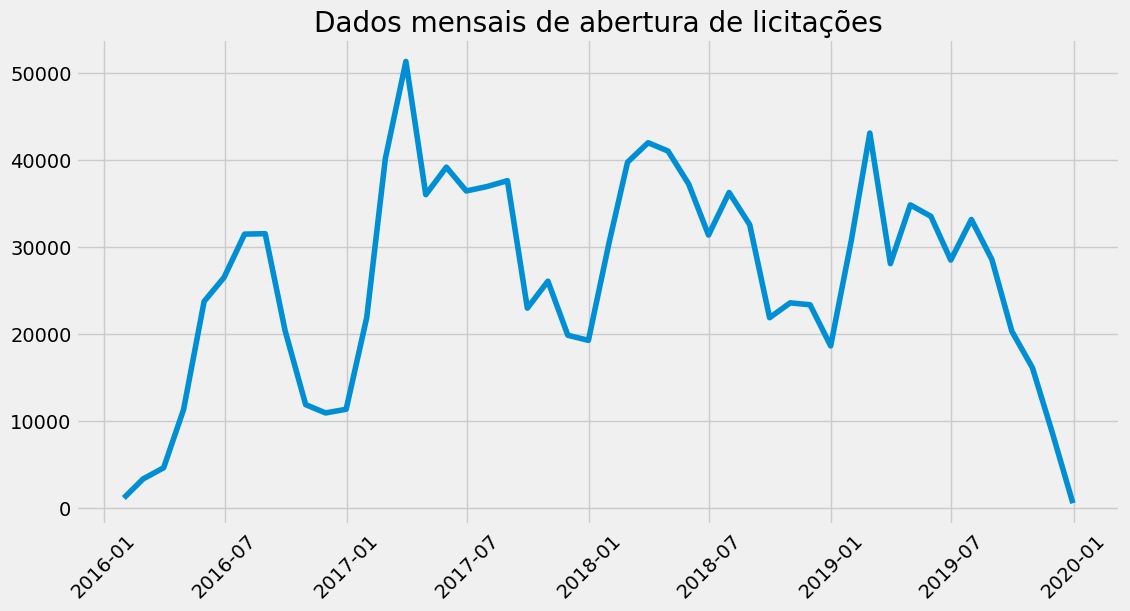

In [38]:
plt.figure(figsize=(12,6))
plt.plot(df_series.resample('M').sum().index,df_series.resample('M').sum().ABERTURAS)
plt.title('Dados mensais de abertura de licitações')
plt.tick_params(labelrotation=45, axis= 'x')

Abaixo criamos um modelo para decomposição da série temporal em:

- Tendência (trend): Crescimento ou decrescimento ao longo do tempo
- Sazionalidade (seasonal): Padrão que se repete em um intervalo regular de tempo

Os resíduos são a diferença entre os valores observados (reais) e os valores ajustados do modelo

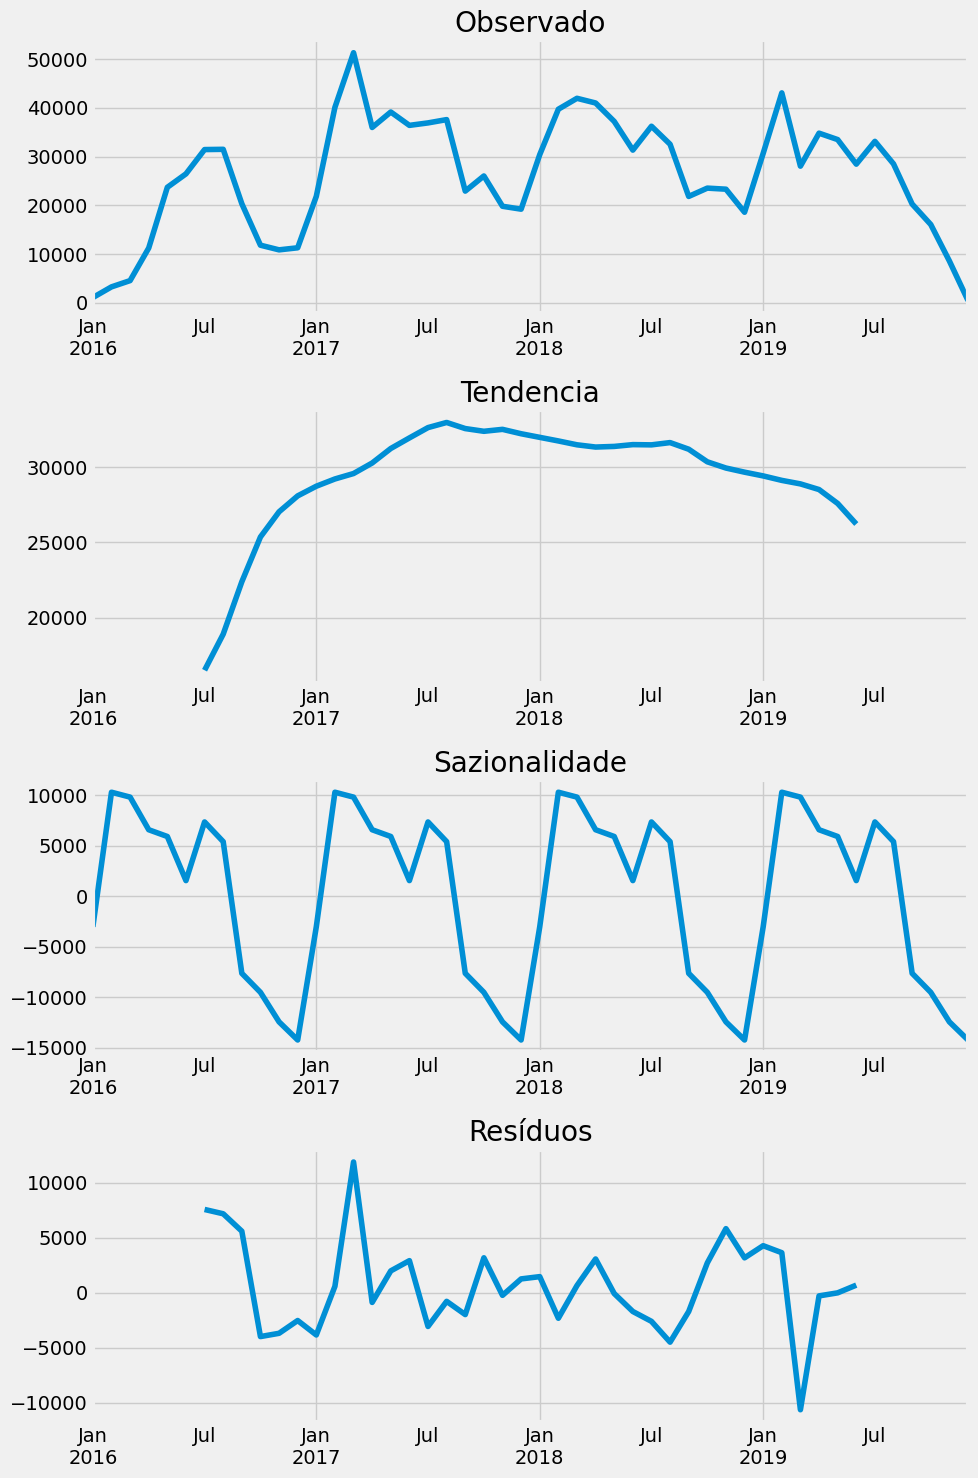

In [40]:

model_ts = seasonal_decompose(df_series.resample('M').sum(), model='additive',)

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(10,15))

model_ts.observed.plot(ax=ax[0])
ax[0].set_title('Observado')
ax[0].set_xlabel('')

model_ts.trend.plot(ax=ax[1])
ax[1].set_title('Tendencia')
ax[1].set_xlabel('')

model_ts.seasonal.plot(ax=ax[2])
ax[2].set_title('Sazionalidade')
ax[2].set_xlabel('')

model_ts.resid.plot(ax=ax[3])
ax[3].set_title('Resíduos')
ax[3].set_xlabel('')

plt.tight_layout()

O número de licitações apresenta uma tendência de crescimento em 2016 e descrescimento em 2019. Existe uma sazionalidade de 12 meses, geralmente com mais licitações à partir de fevereiro com decrescimo a partir de agosto.
Para uma decomposição confiável é necessário garantir que os resíduos estejam normalmente distribuídos. Para isso pode-se realizar o teste de Shapiro-Wilk, o p-valor acima de 0.05 indica que os dados estão normalizados.

In [41]:
shapiro(model_ts.resid.dropna()).pvalue

0.5313146710395813

O resultado acima parece indicar que a análise na tendência e sazionalidade estão coerentes. Pode-se também olhar para a autocorrelação da série.

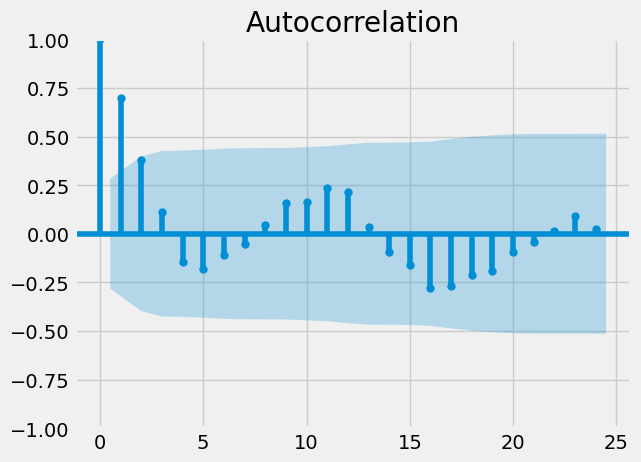

In [42]:
tsaplots.plot_acf(model_ts.observed, lags=24);

A autocorrelação parece indicar a sazionalidade de 12 meses, assim como a decomposição. Podemos olhar as licitações por mês.

In [43]:
df_series_month = df_series.groupby([lambda x: x.month]).sum()

Text(0, 0.5, 'Quantidade')

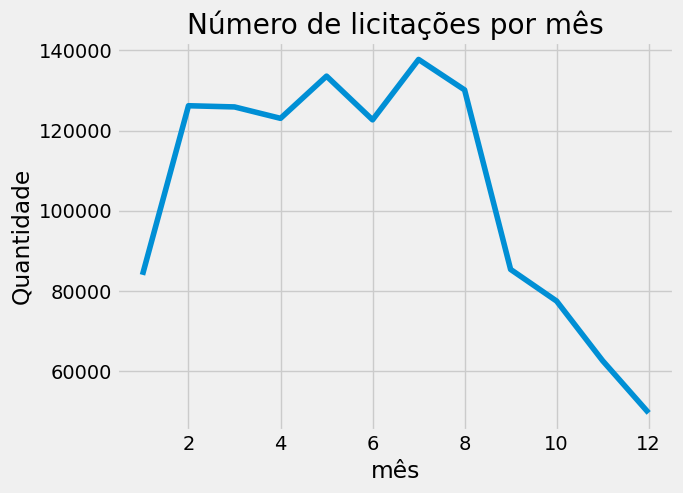

In [45]:
plt.plot(df_series_month.index,df_series_month)
plt.title('Número de licitações por mês')
plt.xlabel('mês')
plt.ylabel('Quantidade')

Como inferido anteriormente o número total de licitações é maior entre fevereiro e julho. Decrescendo à partir de agosto.

## Categorias

Vamos analisar um pouco melhor as categorias, para isso vamos nos focar nas 5 mais frequentes

In [55]:
# Armazena os datasets filtrados por categoria em um dicionario

df_series_objetos = {}
for obj in top5_objetos[0]:
    df_series_objetos[obj] = df[df.DS_OBJETO_RESUMIDO == obj][['DT_ABERTURA', 'DS_OBJETO_RESUMIDO']]\
                .set_index('DT_ABERTURA')

    df_series_objetos[obj].columns = ['ABERTURAS']
    df_series_objetos[obj]['ABERTURAS'] = 1
    df_series_objetos[obj] = df_series_objetos[obj].resample('d').sum()

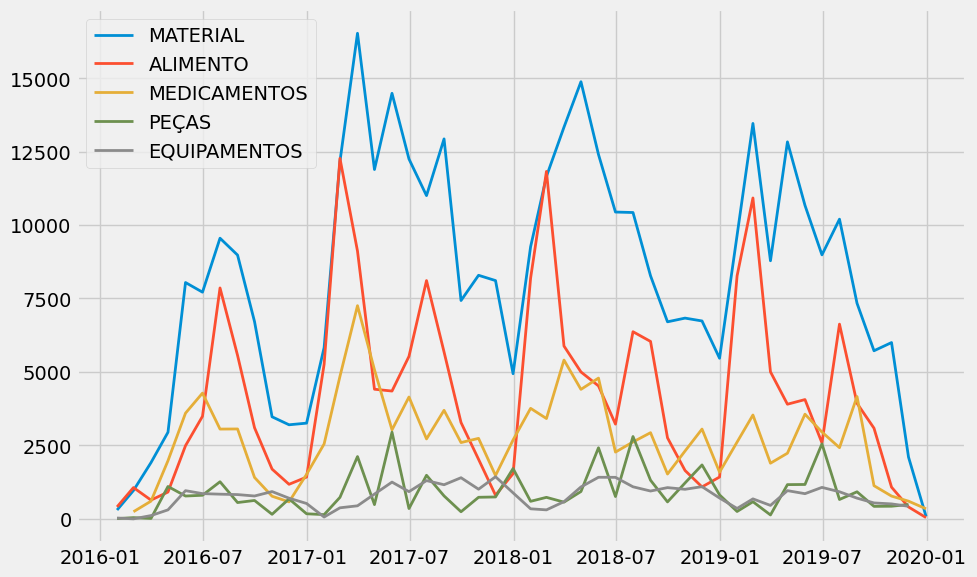

In [56]:
# Gráfico das licitações por categoria (dados mensais)

list_size = len(top5_objetos[0])
plt.figure(figsize=(10,6))

for i,obj in enumerate(top5_objetos[0]):
    plt.plot(df_series_objetos[obj].resample('M').sum().index, df_series_objetos[obj].resample('M').sum().ABERTURAS, label=f'{obj}', linewidth=2)

plt.legend()
plt.tight_layout()

A compra de preças e equipamentos parecem ocorrer quase uniformemente ao longo do ano. Materiais e medicamentos possuem um período com mais compras (fevereiro - julho) equanto a compra de alimentos é maior em curtos períodos, o que nos leva a inferir que eles são estocados. Estocar alimentos pode ou não ser vantajoso, seria interessante acompanhar os preços ao longo do ano para conclusões mais acuradas.

Agrupar os dados por mês pode nos ajudar a confirmar as inferencias anteriores.

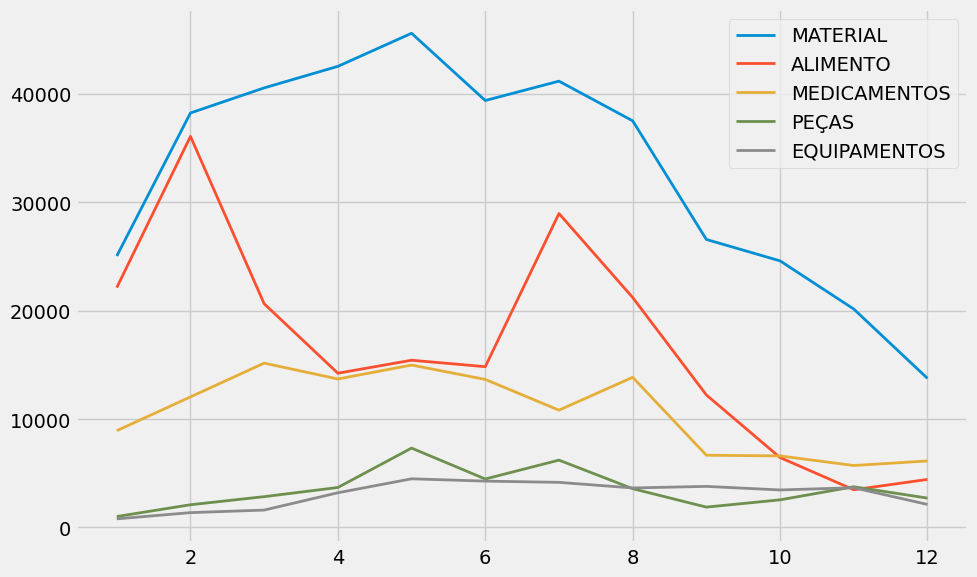

In [57]:
list_size = len(top5_objetos[0])
plt.figure(figsize=(10,6))

for i,obj in enumerate(top5_objetos[0]):
    plt.plot(df_series_objetos[obj].groupby([lambda x: x.month]).sum().index, df_series_objetos[obj].groupby([lambda x: x.month]).sum().ABERTURAS, label=f'{obj}', linewidth=2)

plt.legend()
plt.tight_layout()


A compra de alimento pode estar relacionada com a merenda escolar, com volume maior de licitações antes do começo das aulas após férias.

## Materiais

A compra de materiais é a maior em licitações.

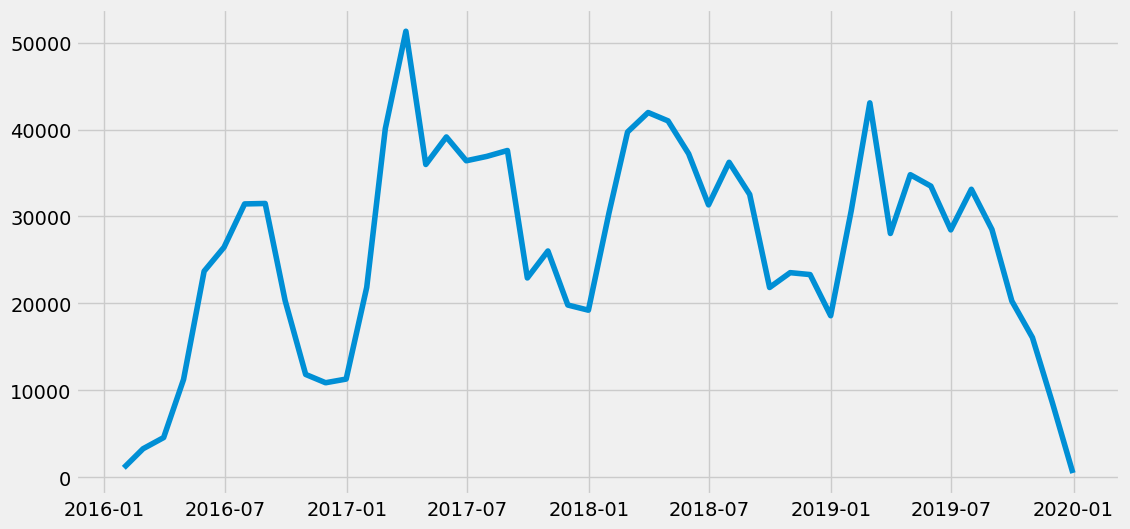

In [58]:
plt.figure(figsize=(12,6))
plt.plot(df_series.resample('M').sum().index,df_series.resample('M').sum().ABERTURAS)

Vamos fazer o mesmo que fizemos para as categorias, mas agora para os itens dentro da categoria materiais.

In [74]:
df_series_items = {}

df_materiais = df[df.DS_OBJETO_RESUMIDO == "MATERIAL"]
top3_items = df_materiais.DS_ITEM_RESUMIDO.value_counts().index[:3]

for item in top3_items:
    df_series_items[item] = df_materiais[df_materiais.DS_ITEM_RESUMIDO == item][['DT_ABERTURA', 'DS_ITEM_RESUMIDO']]\
                .set_index('DT_ABERTURA')

    df_series_items[item].columns = ['ABERTURAS']
    df_series_items[item]['ABERTURAS'] = 1
    df_series_items[item] = df_series_items[item].resample('d').sum()

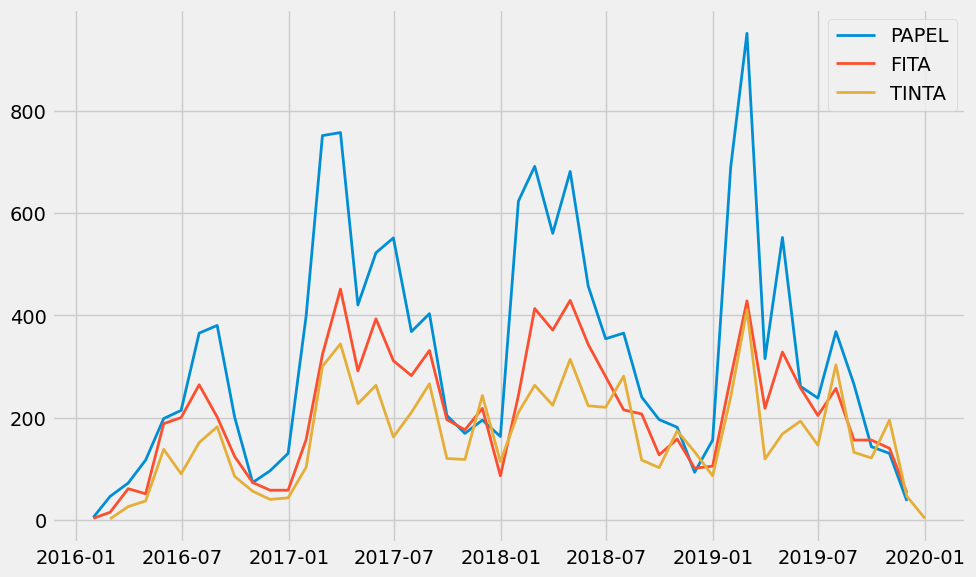

In [76]:
list_size = len(top3_items)
plt.figure(figsize=(10,6))

for i,item in enumerate(top3_items):
    plt.plot(df_series_items[item].resample('M').sum().index, df_series_items[item].resample('M').sum().ABERTURAS, label=f'{item}', linewidth=2)

plt.legend()
plt.tight_layout()

Todos os itens são similares na periodicidade, que é a mesma da categoria.

# Gastos

In [77]:
df_series_gastos = df[['DT_ABERTURA', 'VL_TOTAL_HOMOLOGADO']]\
            .set_index('DT_ABERTURA')
df_series_gastos = df_series_gastos.resample('d').sum()
df_series_gastos = df_series_gastos['2016-01-01':'2019-12-31']

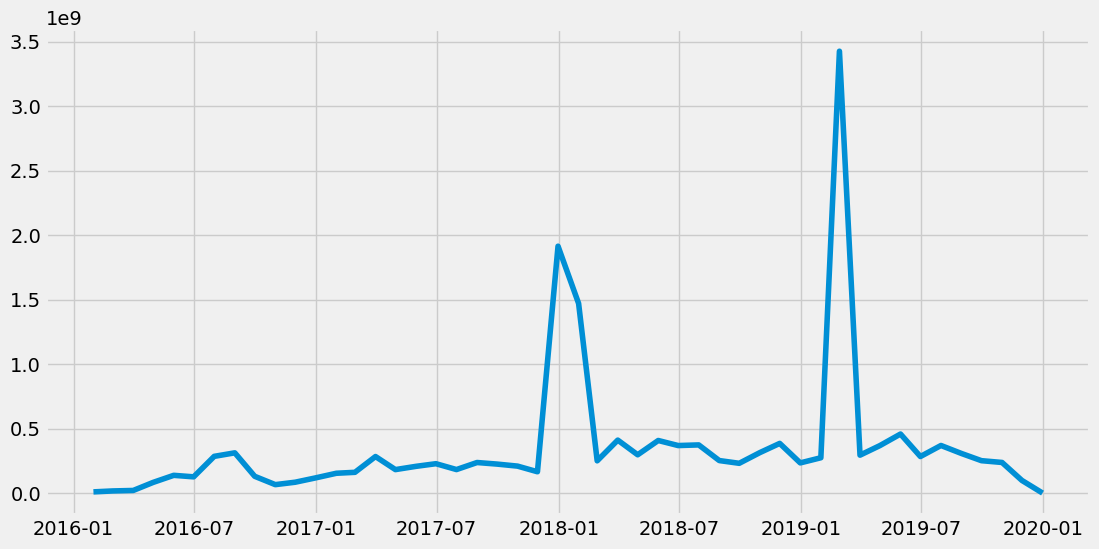

In [78]:
plt.figure(figsize=(12,6))
plt.plot(df_series_gastos.resample('M').sum().index, df_series_gastos.resample('M').sum().VL_TOTAL_HOMOLOGADO)

No pré-processamento foram encontrados inúmeros valores inconsistentes. Embora não tenhamos uma estatística consistente, apenas para termos uma idéia, vou considerar como outliers valores totais acima da mediana mais 50% do desvio padrão.

In [92]:
# calculo do desvio padrão, mediana e média

standard_deviation_total_value = df_series_gastos.VL_TOTAL_HOMOLOGADO.std()
median_total_value = df_series_gastos.VL_TOTAL_HOMOLOGADO.median()
mean_total_value = df_series_gastos.VL_TOTAL_HOMOLOGADO.mean()

Text(0.5, 1.0, 'Histograma dos valores totais das licitações')

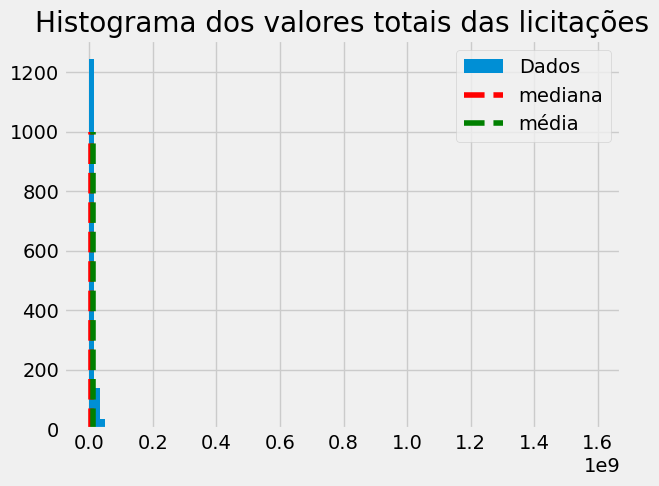

In [93]:
plt.hist(df_series_gastos.VL_TOTAL_HOMOLOGADO,bins=100, label='Dados')
plt.vlines(median_total_value,ymin=0,ymax=1000, colors='red', label='mediana', linestyles='dashed')
plt.vlines(mean_total_value,ymin=0,ymax=1000, colors='green',label='média', linestyles='dashed')
plt.legend()
plt.title('Histograma dos valores totais das licitações')

In [94]:
df_series_gastos_std = df_series_gastos[df_series_gastos.VL_TOTAL_HOMOLOGADO < (median_total_value+0.5*standard_deviation_total_value)]

Text(0.5, 1.0, 'Histograma dos valores totais das licitações')

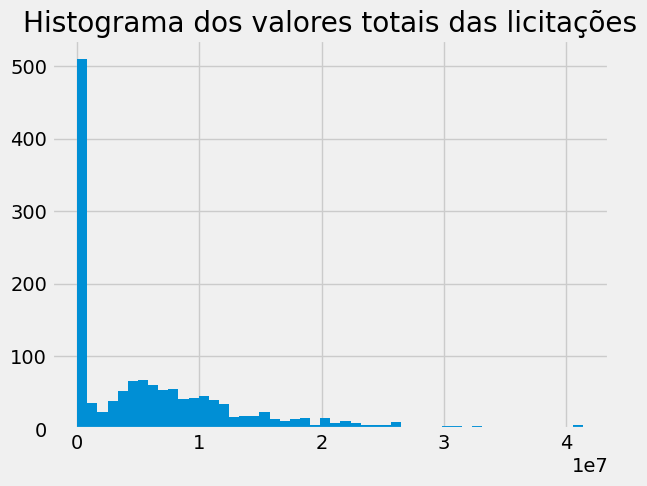

In [95]:
plt.hist(df_series_gastos_std.VL_TOTAL_HOMOLOGADO,bins=50, label='Dados')
plt.title('Histograma dos valores totais das licitações')

Agora o valor das licitações está melhor distribuido. O resultado sem os outliers é visto abaixo.

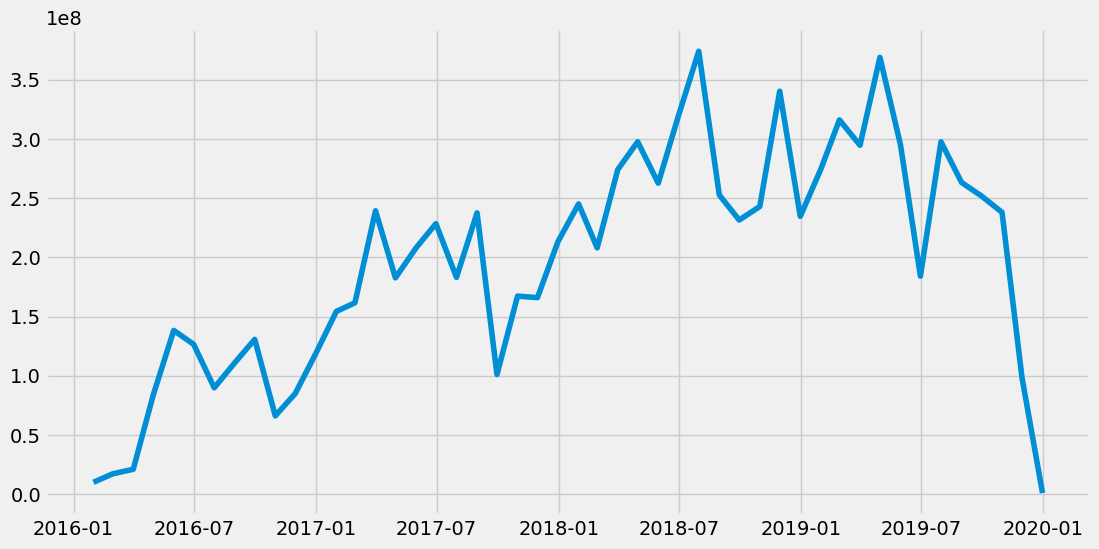

In [97]:
plt.figure(figsize=(12,6))
plt.plot(df_series_gastos_std.resample('M').sum().index, df_series_gastos_std.resample('M').sum().VL_TOTAL_HOMOLOGADO)

A decomposição é feita igual anteriormente para o número de licitações

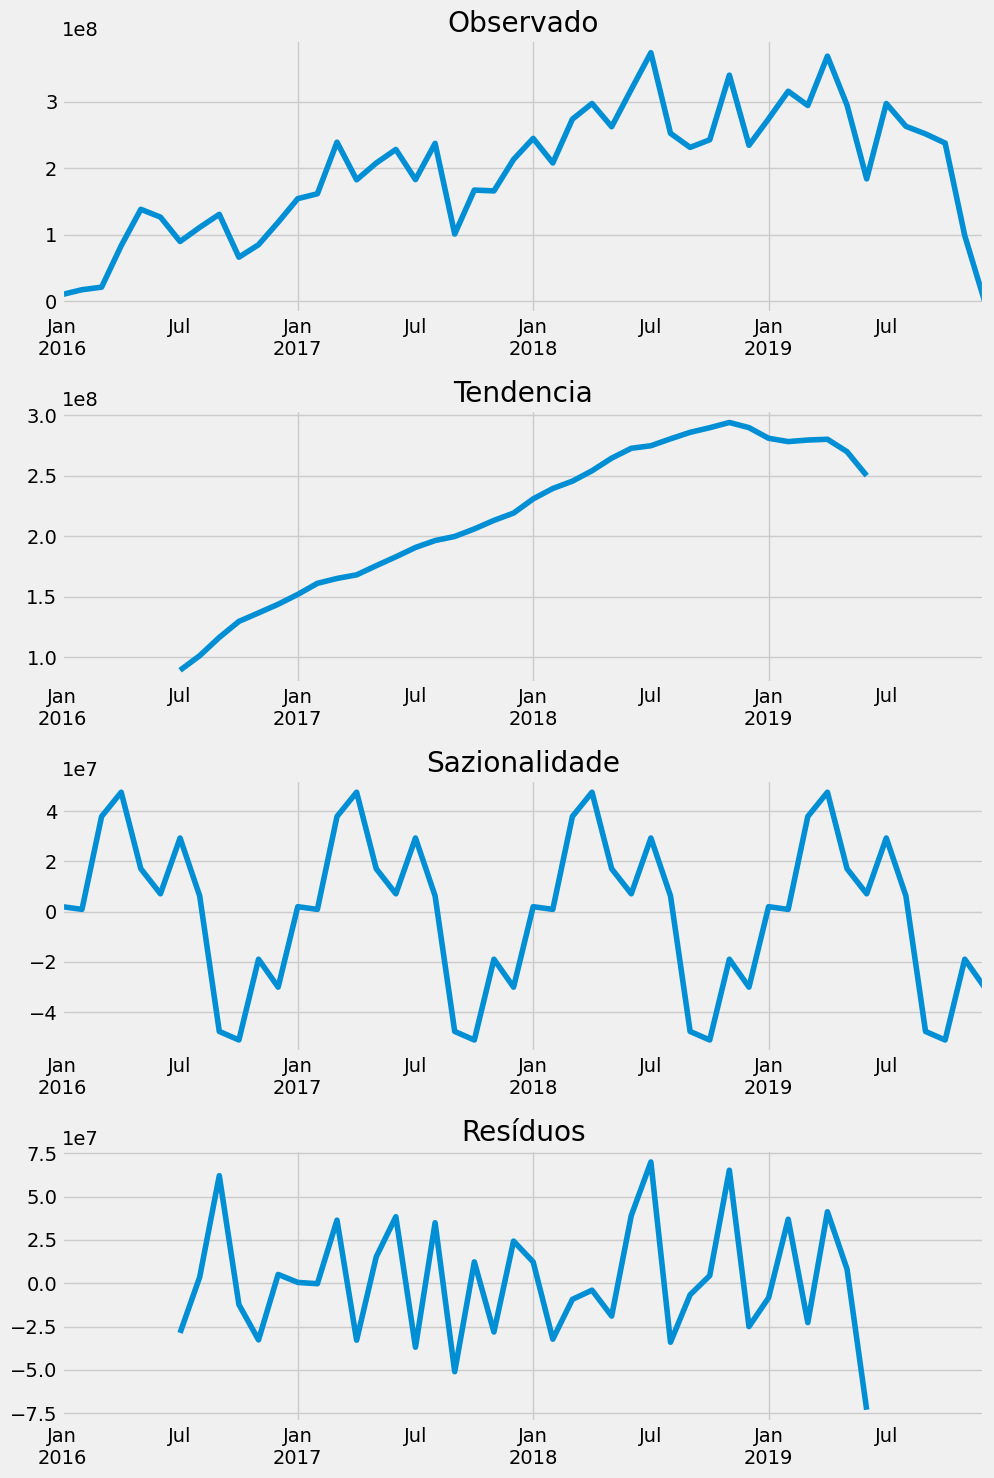

In [98]:
model_ts = seasonal_decompose(df_series_gastos_std.resample('M').sum(), model='additive',)

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(10,15))

model_ts.observed.plot(ax=ax[0])
ax[0].set_title('Observado')
ax[0].set_xlabel('')

model_ts.trend.plot(ax=ax[1])
ax[1].set_title('Tendencia')
ax[1].set_xlabel('')

model_ts.seasonal.plot(ax=ax[2])
ax[2].set_title('Sazionalidade')
ax[2].set_xlabel('')

model_ts.resid.plot(ax=ax[3])
ax[3].set_title('Resíduos')
ax[3].set_xlabel('')

plt.tight_layout()

In [99]:
shapiro(model_ts.resid.dropna()).pvalue

0.6202102303504944

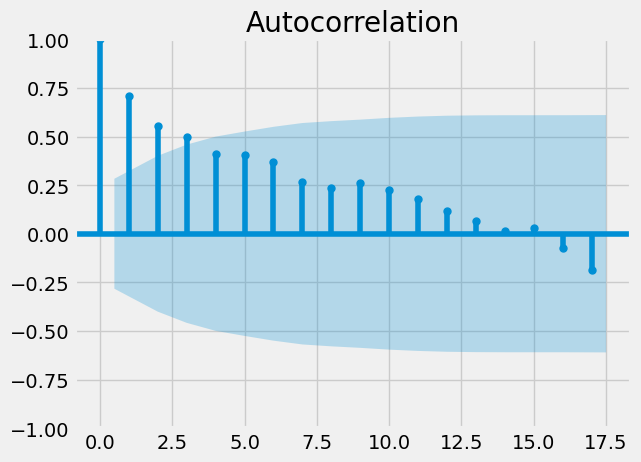

In [100]:
tsaplots.plot_acf(model_ts.observed);

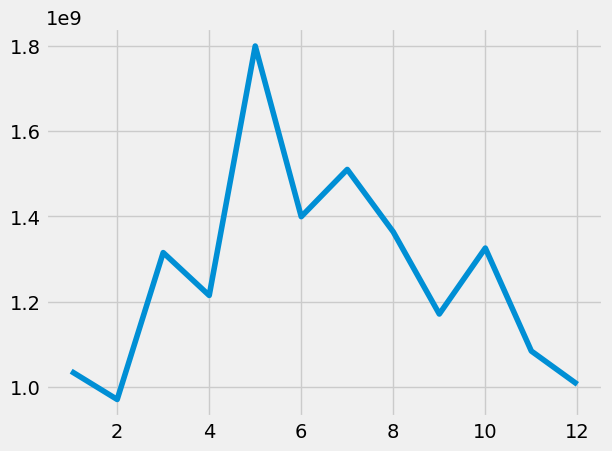

In [241]:
df_series_gastos_std_month = df_series_gastos_std.groupby([lambda x: x.month]).sum()
plt.plot(df_series_gastos_std_month.index, df_series_gastos_std_month.VL_TOTAL_HOMOLOGADO)

Os resultados são parecidos com os obtidos para o número de licitações

# Previsão

O modelo utilizado para a previsão é o SARIMA, este modelo é composto por:
- S: parte sazional
- AR: modelo auto-regressivo
- I: Integração, vem da diferenciação da série temporal
- MA: modelo de médias móveis


In [132]:
model = SARIMAX(df_series_gastos_std,order=(2,1,1), seasonal_order=(1,1,2,12))
model_fit = model.fit()

C:\Users\roger\Documents\pytorch_venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\roger\Documents\pytorch_venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [133]:
# Previsão do modelo para comparação com os dados reais

forecast = model_fit.predict(start = '2019-07-01',end='2019-12-01', dynamic=True)

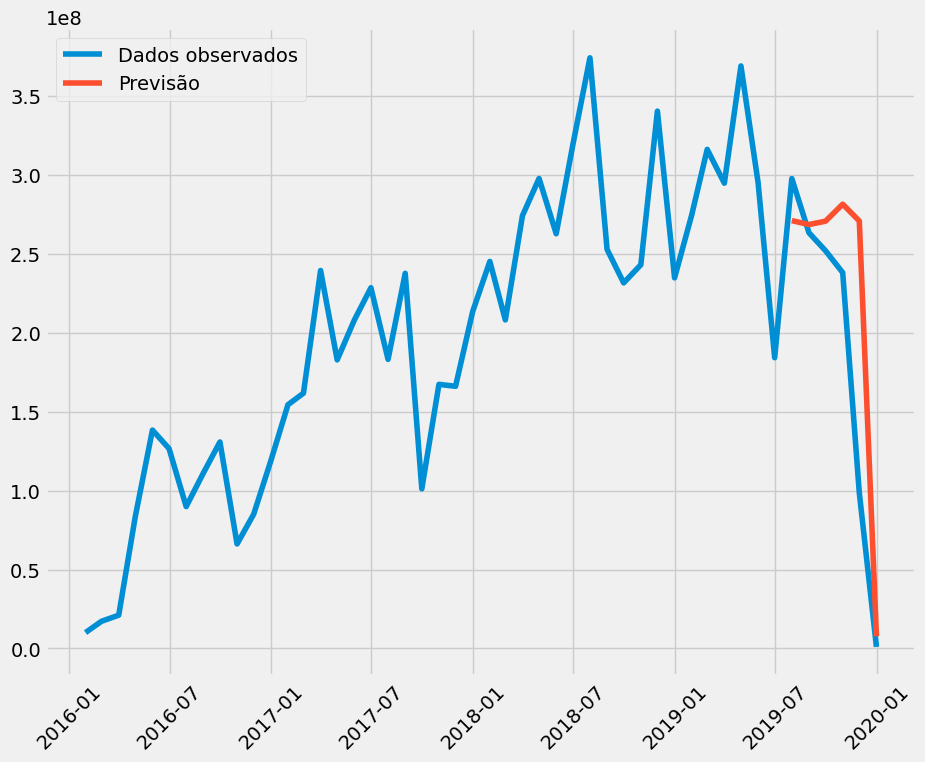

In [134]:
# Visualização

plt.figure(figsize=(10,8))
plt.plot(df_series_gastos_std.resample('M').sum().index,df_series_gastos_std.VL_TOTAL_HOMOLOGADO.resample('M').sum(), label ='Dados observados')
plt.plot(forecast.resample('M').sum().index, forecast.resample('M').sum(), label='Previsão')
plt.tick_params(labelrotation = 45, axis='x')
plt.legend()

As previsões são coerentes com os dados observados